# 👥 Customer Segmentation - Advanced Analytics

This notebook focuses on customer segmentation using various clustering techniques and RFM analysis.

## Objectives:
- Implement RFM (Recency, Frequency, Monetary) analysis
- Apply K-Means clustering for customer segmentation
- Explore hierarchical clustering techniques
- Analyze customer segments and create personas
- Develop targeted marketing strategies
- Validate segmentation results


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import warnings
warnings.filterwarnings('ignore')

# Import custom modules
import sys
sys.path.append('../src')
from components.customer_segmentation import CustomerSegmentation

print("📚 Customer segmentation libraries loaded!")

📚 Customer segmentation libraries loaded!


In [2]:
# Load data
try:
    df = pd.read_csv('../data/processed/cleaned_data.csv')
    print(f"✅ Cleaned dataset loaded: {df.shape}")
except FileNotFoundError:
    print("📊 Loading raw data for processing...")
    try:
        df = pd.read_csv('../data/raw/customer_shopping_data.csv')
    except FileNotFoundError:
        from src.utils.common import load_sample_data
        df = load_sample_data(n_customers=2000)
    print(f"Dataset shape: {df.shape}")

# Display basic info
print("\n📋 Dataset Overview:")
print(f"Records: {len(df):,}")
if 'Customer ID' in df.columns:
    print(f"Unique Customers: {df['Customer ID'].nunique():,}")
print(f"Features: {df.shape[1]}")

📊 Loading raw data for processing...
Dataset shape: (3900, 19)

📋 Dataset Overview:
Records: 3,900
Unique Customers: 3,900
Features: 19


## 1. Data Preparation for Segmentation

In [3]:
# Prepare features for clustering
def prepare_segmentation_features(df):
    """Prepare features for customer segmentation"""
    features = pd.DataFrame()
    
    # Customer-level aggregation
    if 'Customer ID' in df.columns:
        customer_features = df.groupby('Customer ID').agg({
            'Purchase Amount (USD)': ['sum', 'mean', 'count', 'std'] if 'Purchase Amount (USD)' in df.columns else None,
            'Age': 'first' if 'Age' in df.columns else None,
            'Review Rating': 'mean' if 'Review Rating' in df.columns else None,
            'Category': 'nunique' if 'Category' in df.columns else None
        }).fillna(0)
        
        # Flatten column names
        customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]
        customer_features = customer_features.reset_index()
        
        features = customer_features
    else:
        # Use individual transaction features if no customer ID
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        features = df[numeric_cols].fillna(0)
    
    print(f"📊 Features prepared: {features.shape}")
    print(f"Feature columns: {list(features.columns)}")
    
    return features

features_df = prepare_segmentation_features(df)
display(features_df.head())

📊 Features prepared: (3900, 8)
Feature columns: ['Customer ID', 'Purchase Amount (USD)_sum', 'Purchase Amount (USD)_mean', 'Purchase Amount (USD)_count', 'Purchase Amount (USD)_std', 'Age_first', 'Review Rating_mean', 'Category_nunique']


,Customer ID,Purchase Amount (USD)_sum,Purchase Amount (USD)_mean,Purchase Amount (USD)_count,Purchase Amount (USD)_std,Age_first,Review Rating_mean,Category_nunique
0,1,53,53.0,1,0.0,55,3.1,1
1,2,64,64.0,1,0.0,19,3.1,1
2,3,73,73.0,1,0.0,50,3.1,1
3,4,90,90.0,1,0.0,21,3.5,1
4,5,49,49.0,1,0.0,45,2.7,1


In [4]:
# Create RFM features
def create_rfm_features(df):
    """Create RFM (Recency, Frequency, Monetary) features"""
    
    if 'Customer ID' not in df.columns:
        print("⚠️ Customer ID not found. Creating synthetic RFM data...")
        # Create synthetic RFM data
        n_customers = min(1000, len(df))
        np.random.seed(42)
        
        rfm_df = pd.DataFrame({
            'Customer_ID': [f'CUST_{i:05d}' for i in range(n_customers)],
            'Recency': np.random.exponential(30, n_customers),  # Days since last purchase
            'Frequency': np.random.poisson(5, n_customers),     # Number of purchases
            'Monetary': np.random.exponential(200, n_customers) # Total spend
        })
    else:
        # Calculate actual RFM from data
        reference_date = pd.to_datetime('2024-01-01')  # Use a reference date
        
        if 'Purchase Date' in df.columns:
            df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
            
            rfm_df = df.groupby('Customer ID').agg({
                'Purchase Date': lambda x: (reference_date - x.max()).days,
                'Customer ID': 'count',
                'Purchase Amount (USD)': 'sum' if 'Purchase Amount (USD)' in df.columns else None
            })
            
            rfm_df.columns = ['Recency', 'Frequency', 'Monetary']
            rfm_df = rfm_df.reset_index()
        else:
            # Use aggregated features as proxy
            if 'Purchase Amount (USD)' in df.columns:
                customer_agg = df.groupby('Customer ID').agg({
                    'Purchase Amount (USD)': ['sum', 'count']
                })
                customer_agg.columns = ['Monetary', 'Frequency']
                customer_agg['Recency'] = np.random.exponential(30, len(customer_agg))
                rfm_df = customer_agg.reset_index()
            else:
                # Fallback to synthetic data
                n_customers = df['Customer ID'].nunique()
                rfm_df = pd.DataFrame({
                    'Customer ID': df['Customer ID'].unique(),
                    'Recency': np.random.exponential(30, n_customers),
                    'Frequency': np.random.poisson(5, n_customers),
                    'Monetary': np.random.exponential(200, n_customers)
                })
    
    print(f"✅ RFM features created for {len(rfm_df)} customers")
    return rfm_df

rfm_data = create_rfm_features(df)
display(rfm_data.head())
display(rfm_data.describe())

✅ RFM features created for 3900 customers


,Customer ID,Monetary,Frequency,Recency
0,1,53,1,61.587991
1,2,64,1,29.975162
2,3,73,1,73.599334
3,4,90,1,16.090498
4,5,49,1,44.022094


,Customer ID,Monetary,Frequency,Recency
count,3900.000000,3900.000000,3900.0,3900.000000
mean,1950.500000,59.764359,1.0,29.991030
std,1125.977353,23.685392,0.0,31.019593
min,1.000000,20.000000,1.0,0.008295
25%,975.750000,39.000000,1.0,8.473800
50%,1950.500000,60.000000,1.0,20.443027
75%,2925.250000,81.000000,1.0,41.444899
max,3900.000000,100.000000,1.0,267.317091


## 2. RFM Analysis and Segmentation

In [5]:
# RFM Scoring and Segmentation
def create_rfm_segments(rfm_df):
    """Create RFM segments based on quintile scoring"""
    
    # Create RFM scores (quintiles)
    rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1])  # Lower recency = higher score
    rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])  # Higher frequency = higher score
    rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])   # Higher monetary = higher score
    
    # Convert to integers
    rfm_df['R_Score'] = rfm_df['R_Score'].astype(int)
    rfm_df['F_Score'] = rfm_df['F_Score'].astype(int)
    rfm_df['M_Score'] = rfm_df['M_Score'].astype(int)
    
    # Create RFM combined score
    rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)
    
    # Define segment rules
    def assign_segment(row):
        if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
            return 'Champions'
        elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
            return 'Loyal Customers'
        elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
            return 'New Customers'
        elif row['R_Score'] >= 3 and row['F_Score'] <= 2 and row['M_Score'] >= 3:
            return 'Potential Loyalists'
        elif row['R_Score'] <= 2 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
            return 'At Risk'
        elif row['R_Score'] <= 2 and row['F_Score'] >= 2 and row['M_Score'] <= 2:
            return 'Cannot Lose Them'
        elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
            return 'Lost Customers'
        else:
            return 'Others'
    
    rfm_df['RFM_Segment'] = rfm_df.apply(assign_segment, axis=1)
    
    return rfm_df

# Apply RFM segmentation
rfm_segmented = create_rfm_segments(rfm_data.copy())

# Display segment distribution
segment_dist = rfm_segmented['RFM_Segment'].value_counts()
print("🎯 RFM SEGMENT DISTRIBUTION:")
print("=" * 40)
for segment, count in segment_dist.items():
    percentage = (count / len(rfm_segmented)) * 100
    print(f"{segment:<20}: {count:>4} ({percentage:>5.1f}%)")

# Visualize RFM segments
fig = px.pie(
    values=segment_dist.values,
    names=segment_dist.index,
    title='Customer Segments Distribution (RFM Analysis)',
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

🎯 RFM SEGMENT DISTRIBUTION:
Others              :  672 ( 17.2%)
New Customers       :  625 ( 16.0%)
Loyal Customers     :  598 ( 15.3%)
At Risk             :  558 ( 14.3%)
Cannot Lose Them    :  507 ( 13.0%)
Lost Customers      :  495 ( 12.7%)
Champions           :  256 (  6.6%)
Potential Loyalists :  189 (  4.8%)


In [6]:
# RFM Segment Analysis
def analyze_rfm_segments(rfm_df):
    """Analyze characteristics of each RFM segment"""
    
    segment_analysis = rfm_df.groupby('RFM_Segment').agg({
        'Recency': ['mean', 'median'],
        'Frequency': ['mean', 'median'],
        'Monetary': ['mean', 'median'],
        'RFM_Segment': 'count'
    }).round(2)
    
    segment_analysis.columns = ['Recency_Mean', 'Recency_Median', 'Frequency_Mean', 'Frequency_Median', 
                               'Monetary_Mean', 'Monetary_Median', 'Customer_Count']
    
    return segment_analysis

segment_stats = analyze_rfm_segments(rfm_segmented)
print("📊 SEGMENT CHARACTERISTICS:")
display(segment_stats)

# Create segment comparison visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Average Recency by Segment', 'Average Frequency by Segment', 
                   'Average Monetary by Segment', 'Customer Count by Segment']
)

# Recency
fig.add_trace(
    go.Bar(x=segment_stats.index, y=segment_stats['Recency_Mean'], name='Recency'),
    row=1, col=1
)

# Frequency
fig.add_trace(
    go.Bar(x=segment_stats.index, y=segment_stats['Frequency_Mean'], name='Frequency'),
    row=1, col=2
)

# Monetary
fig.add_trace(
    go.Bar(x=segment_stats.index, y=segment_stats['Monetary_Mean'], name='Monetary'),
    row=2, col=1
)

# Customer Count
fig.add_trace(
    go.Bar(x=segment_stats.index, y=segment_stats['Customer_Count'], name='Count'),
    row=2, col=2
)

fig.update_xaxes(tickangle=45)
fig.update_layout(height=800, title_text="RFM Segment Analysis", showlegend=False)
fig.show()

📊 SEGMENT CHARACTERISTICS:


,Recency_Mean,Recency_Median,Frequency_Mean,Frequency_Median,Monetary_Mean,Monetary_Median,Customer_Count
RFM_Segment,,,,,,,
At Risk,59.09,47.28,1.0,1.0,76.83,78.0,558
Cannot Lose Them,56.71,46.62,1.0,1.0,35.34,36.0,507
Champions,6.91,6.73,1.0,1.0,84.43,84.0,256
Lost Customers,57.68,48.37,1.0,1.0,67.81,70.0,495
Loyal Customers,12.89,13.43,1.0,1.0,72.38,70.0,598
New Customers,6.77,6.35,1.0,1.0,57.93,57.0,625
Others,13.59,13.86,1.0,1.0,34.64,34.0,672
Potential Loyalists,20.35,20.28,1.0,1.0,75.90,75.0,189


## 3. K-Means Clustering Analysis

In [7]:
# Prepare data for K-means clustering
def prepare_clustering_data(rfm_df):
    """Prepare and scale data for clustering"""
    
    # Select features for clustering
    clustering_features = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()
    
    # Handle outliers (cap at 95th percentile)
    for col in clustering_features.columns:
        cap_value = clustering_features[col].quantile(0.95)
        clustering_features[col] = np.where(clustering_features[col] > cap_value, cap_value, clustering_features[col])
    
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_features)
    scaled_df = pd.DataFrame(scaled_features, columns=clustering_features.columns)
    
    return scaled_df, scaler, clustering_features

scaled_data, scaler, original_features = prepare_clustering_data(rfm_segmented)
print(f"✅ Clustering data prepared: {scaled_data.shape}")
print(f"Features: {list(scaled_data.columns)}")

# Show scaling effect
print("\n📊 SCALING COMPARISON:")
print("Original data:")
display(original_features.describe())
print("\nScaled data:")
display(scaled_data.describe())

✅ Clustering data prepared: (3900, 3)
Features: ['Recency', 'Frequency', 'Monetary']

📊 SCALING COMPARISON:
Original data:


,Recency,Frequency,Monetary
count,3900.000000,3900.0,3900.000000
mean,28.285173,1.0,59.649167
std,25.197724,0.0,23.501046
min,0.008295,1.0,20.000000
25%,8.473800,1.0,39.000000
50%,20.443027,1.0,60.000000
75%,41.444899,1.0,81.000000
max,90.619564,1.0,96.050000



Scaled data:


,Recency,Frequency,Monetary
count,3.900000e+03,3900.0,3.900000e+03
mean,8.380760e-17,0.0,5.465713e-17
std,1.000128e+00,0.0,1.000128e+00
min,-1.122344e+00,0.0,-1.687340e+00
25%,-7.863374e-01,0.0,-8.787615e-01
50%,-3.112643e-01,0.0,1.493033e-02
75%,5.223255e-01,0.0,9.086222e-01
max,2.474128e+00,0.0,1.549101e+00


In [8]:
# Find optimal number of clusters
def find_optimal_clusters(data, max_clusters=10):
    """Find optimal number of clusters using elbow method and silhouette score"""
    
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    return K_range, inertias, silhouette_scores

# Find optimal clusters
k_range, inertias, sil_scores = find_optimal_clusters(scaled_data)

# Plot elbow curve and silhouette scores
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Elbow Method', 'Silhouette Score']
)

# Elbow method
fig.add_trace(
    go.Scatter(x=list(k_range), y=inertias, mode='lines+markers', name='Inertia'),
    row=1, col=1
)

# Silhouette score
fig.add_trace(
    go.Scatter(x=list(k_range), y=sil_scores, mode='lines+markers', name='Silhouette Score'),
    row=1, col=2
)

fig.update_xaxes(title_text="Number of Clusters (k)")
fig.update_yaxes(title_text="Inertia", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)
fig.update_layout(height=400, title_text="Optimal Number of Clusters Analysis")
fig.show()

# Find best k based on silhouette score
best_k = k_range[np.argmax(sil_scores)]
best_silhouette = max(sil_scores)

print(f"📊 OPTIMAL CLUSTERING RESULTS:")
print(f"Best number of clusters: {best_k}")
print(f"Best silhouette score: {best_silhouette:.3f}")

# Show silhouette scores for each k
print("\nSilhouette scores by k:")
for k, score in zip(k_range, sil_scores):
    print(f"k={k}: {score:.3f}")

📊 OPTIMAL CLUSTERING RESULTS:
Best number of clusters: 3
Best silhouette score: 0.450

Silhouette scores by k:
k=2: 0.382
k=3: 0.450
k=4: 0.434
k=5: 0.383
k=6: 0.397
k=7: 0.401
k=8: 0.398
k=9: 0.383
k=10: 0.384


In [9]:
# Apply K-means clustering with optimal k
optimal_k = best_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to original data
rfm_clustered = rfm_segmented.copy()
rfm_clustered['KMeans_Cluster'] = cluster_labels

# Analyze K-means clusters
kmeans_analysis = rfm_clustered.groupby('KMeans_Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'KMeans_Cluster': 'count'
}).round(2)

kmeans_analysis.columns = ['Recency_Mean', 'Recency_Std', 'Frequency_Mean', 'Frequency_Std',
                          'Monetary_Mean', 'Monetary_Std', 'Customer_Count']

print(f"🎯 K-MEANS CLUSTERING RESULTS (k={optimal_k}):")
display(kmeans_analysis)

# Visualize clusters in 3D
fig = px.scatter_3d(
    rfm_clustered,
    x='Recency',
    y='Frequency', 
    z='Monetary',
    color='KMeans_Cluster',
    title=f'K-Means Customer Clusters (k={optimal_k})',
    labels={'color': 'Cluster'}
)
fig.show()

# Show cluster distribution
cluster_dist = rfm_clustered['KMeans_Cluster'].value_counts().sort_index()
print(f"\n📊 CLUSTER DISTRIBUTION:")
for cluster, count in cluster_dist.items():
    percentage = (count / len(rfm_clustered)) * 100
    print(f"Cluster {cluster}: {count:>4} customers ({percentage:>5.1f}%)")

🎯 K-MEANS CLUSTERING RESULTS (k=3):


,Recency_Mean,Recency_Std,Frequency_Mean,Frequency_Std,Monetary_Mean,Monetary_Std,Customer_Count
KMeans_Cluster,,,,,,,
0,80.22,33.62,1.0,0.0,61.51,21.55,746
1,18.26,13.68,1.0,0.0,38.35,11.45,1587
2,17.96,13.51,1.0,0.0,80.62,11.89,1567



📊 CLUSTER DISTRIBUTION:
Cluster 0:  746 customers ( 19.1%)
Cluster 1: 1587 customers ( 40.7%)
Cluster 2: 1567 customers ( 40.2%)


## 4. Hierarchical Clustering Analysis

📊 Using sample of 500 customers for dendrogram visualization


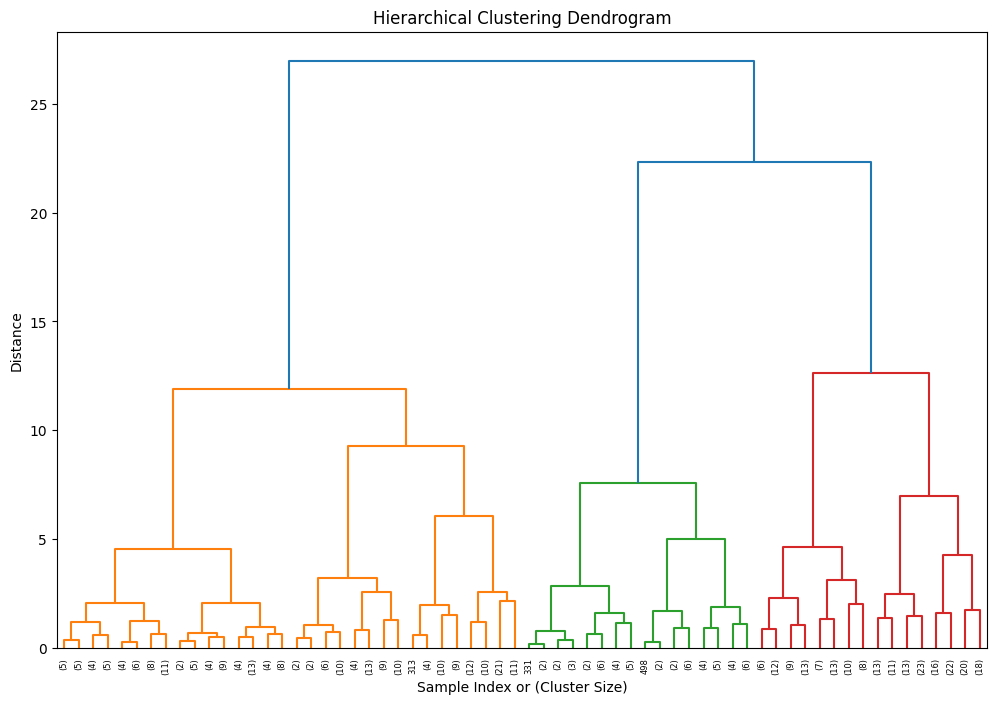

🌳 HIERARCHICAL CLUSTERING RESULTS:


,Recency_Mean,Recency_Std,Frequency_Mean,Frequency_Std,Monetary_Mean,Monetary_Std,Customer_Count
Hierarchical_Cluster,,,,,,,
0,60.85,32.57,1.0,0.0,63.70,23.40,1394
1,13.83,9.69,1.0,0.0,39.08,11.80,1382
2,11.59,8.18,1.0,0.0,80.31,11.36,1124


In [10]:
# Hierarchical clustering
def perform_hierarchical_clustering(data, n_clusters=None, sample_size=500):
    """Perform hierarchical clustering with dendrogram visualization"""
    
    # Sample data for visualization if too large
    if len(data) > sample_size:
        sample_idx = np.random.choice(len(data), sample_size, replace=False)
        data_sample = data.iloc[sample_idx]
        print(f"📊 Using sample of {sample_size} customers for dendrogram visualization")
    else:
        data_sample = data
    
    # Create dendrogram
    linkage_matrix = linkage(data_sample, method='ward')
    
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index or (Cluster Size)')
    plt.ylabel('Distance')
    plt.show()
    
    # Apply hierarchical clustering to full dataset
    if n_clusters is None:
        n_clusters = optimal_k  # Use same as K-means for comparison
    
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    hierarchical_labels = hierarchical.fit_predict(data)
    
    return hierarchical_labels

# Perform hierarchical clustering
hierarchical_labels = perform_hierarchical_clustering(scaled_data, optimal_k)

# Add hierarchical cluster labels
rfm_clustered['Hierarchical_Cluster'] = hierarchical_labels

# Analyze hierarchical clusters
hierarchical_analysis = rfm_clustered.groupby('Hierarchical_Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'Hierarchical_Cluster': 'count'
}).round(2)

hierarchical_analysis.columns = ['Recency_Mean', 'Recency_Std', 'Frequency_Mean', 'Frequency_Std',
                                'Monetary_Mean', 'Monetary_Std', 'Customer_Count']

print(f"🌳 HIERARCHICAL CLUSTERING RESULTS:")
display(hierarchical_analysis)

## 5. Segmentation Comparison and Validation

In [11]:
# Compare different segmentation methods
def compare_segmentation_methods(df):
    """Compare RFM, K-means, and Hierarchical clustering results"""
    
    comparison_results = {
        'Method': ['RFM Segments', 'K-Means', 'Hierarchical'],
        'Number of Segments': [df['RFM_Segment'].nunique(), 
                              df['KMeans_Cluster'].nunique(), 
                              df['Hierarchical_Cluster'].nunique()],
        'Silhouette Score': []
    }
    
    # Calculate silhouette scores
    methods_data = {
        'RFM': df['RFM_Segment'].astype('category').cat.codes,
        'KMeans': df['KMeans_Cluster'],
        'Hierarchical': df['Hierarchical_Cluster']
    }
    
    for method, labels in methods_data.items():
        try:
            score = silhouette_score(scaled_data, labels)
            comparison_results['Silhouette Score'].append(score)
        except:
            comparison_results['Silhouette Score'].append(np.nan)
    
    comparison_df = pd.DataFrame(comparison_results)
    return comparison_df

# Compare methods
comparison = compare_segmentation_methods(rfm_clustered)
print("🔍 SEGMENTATION METHODS COMPARISON:")
display(comparison)

# Cross-tabulation between methods
print("\n🔄 RFM vs K-Means Segments:")
rfm_kmeans_crosstab = pd.crosstab(rfm_clustered['RFM_Segment'], rfm_clustered['KMeans_Cluster'])
display(rfm_kmeans_crosstab)

print("\n🔄 K-Means vs Hierarchical Clusters:")
kmeans_hierarchical_crosstab = pd.crosstab(rfm_clustered['KMeans_Cluster'], rfm_clustered['Hierarchical_Cluster'])
display(kmeans_hierarchical_crosstab)

🔍 SEGMENTATION METHODS COMPARISON:


,Method,Number of Segments,Silhouette Score
0,RFM Segments,8,0.001460
1,K-Means,3,0.450087
2,Hierarchical,3,0.369672



🔄 RFM vs K-Means Segments:


KMeans_Cluster,0,1,2
RFM_Segment,,,
At Risk,285,27,246
Cannot Lose Them,211,296,0
Champions,0,0,256
Lost Customers,250,80,165
Loyal Customers,0,152,446
New Customers,0,331,294
Others,0,672,0
Potential Loyalists,0,29,160



🔄 K-Means vs Hierarchical Clusters:


Hierarchical_Cluster,0,1,2
KMeans_Cluster,,,
0,746,0,0
1,240,1343,4
2,408,39,1120


In [12]:
# Visualize segmentation comparison
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['RFM Segments', 'K-Means Clusters', 'Hierarchical Clusters', 'Segment Sizes'],
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'bar'}]]
)

# RFM Segments 3D
for i, segment in enumerate(rfm_clustered['RFM_Segment'].unique()):
    segment_data = rfm_clustered[rfm_clustered['RFM_Segment'] == segment]
    fig.add_trace(
        go.Scatter3d(
            x=segment_data['Recency'],
            y=segment_data['Frequency'],
            z=segment_data['Monetary'],
            mode='markers',
            name=segment,
            showlegend=False
        ),
        row=1, col=1
    )

# K-Means Clusters 3D
for cluster in rfm_clustered['KMeans_Cluster'].unique():
    cluster_data = rfm_clustered[rfm_clustered['KMeans_Cluster'] == cluster]
    fig.add_trace(
        go.Scatter3d(
            x=cluster_data['Recency'],
            y=cluster_data['Frequency'],
            z=cluster_data['Monetary'],
            mode='markers',
            name=f'K-Means {cluster}',
            showlegend=False
        ),
        row=1, col=2
    )

# Hierarchical Clusters 3D
for cluster in rfm_clustered['Hierarchical_Cluster'].unique():
    cluster_data = rfm_clustered[rfm_clustered['Hierarchical_Cluster'] == cluster]
    fig.add_trace(
        go.Scatter3d(
            x=cluster_data['Recency'],
            y=cluster_data['Frequency'],
            z=cluster_data['Monetary'],
            mode='markers',
            name=f'Hierarchical {cluster}',
            showlegend=False
        ),
        row=2, col=1
    )

# Segment sizes comparison
methods = ['RFM', 'K-Means', 'Hierarchical']
segment_counts = [
    len(rfm_clustered['RFM_Segment'].unique()),
    len(rfm_clustered['KMeans_Cluster'].unique()),
    len(rfm_clustered['Hierarchical_Cluster'].unique())
]

fig.add_trace(
    go.Bar(x=methods, y=segment_counts, name='Segment Count'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Segmentation Methods Comparison")
fig.show()

## 6. Customer Personas and Business Insights

In [13]:
# Create customer personas based on RFM segments
def create_customer_personas(rfm_df):
    """Create detailed customer personas for each segment"""
    
    personas = {
        'Champions': {
            'description': 'Best customers - high value, frequent purchases, recent activity',
            'characteristics': ['High spending', 'Regular purchases', 'Recently active', 'Highly engaged'],
            'strategy': 'Reward and retain',
            'actions': ['VIP treatment', 'Exclusive offers', 'Early access', 'Loyalty rewards']
        },
        'Loyal Customers': {
            'description': 'Consistent customers with good value and regular engagement',
            'characteristics': ['Moderate to high spending', 'Regular engagement', 'Predictable behavior'],
            'strategy': 'Maintain relationship and increase value',
            'actions': ['Cross-sell', 'Upsell', 'Personalization', 'Relationship building']
        },
        'New Customers': {
            'description': 'Recent customers with potential for growth',
            'characteristics': ['Recent first purchase', 'Low frequency', 'Testing the waters'],
            'strategy': 'Nurture and convert to loyal',
            'actions': ['Welcome series', 'Education', 'Support', 'Incentives for repeat purchase']
        },
        'Potential Loyalists': {
            'description': 'Customers showing signs of increased engagement',
            'characteristics': ['Increasing activity', 'Good value potential', 'Responsive to offers'],
            'strategy': 'Develop into loyal customers',
            'actions': ['Targeted offers', 'Engagement campaigns', 'Value demonstration']
        },
        'At Risk': {
            'description': 'Previously good customers showing declining engagement',
            'characteristics': ['Declining frequency', 'Haven\'t purchased recently', 'High historical value'],
            'strategy': 'Win-back campaigns',
            'actions': ['Re-engagement offers', 'Surveys', 'Personal outreach', 'Special incentives']
        },
        'Cannot Lose Them': {
            'description': 'High-value customers at risk of churning',
            'characteristics': ['High historical spend', 'Infrequent recent activity', 'High churn risk'],
            'strategy': 'Immediate intervention required',
            'actions': ['Personal contact', 'Exclusive offers', 'Account management', 'Problem resolution']
        },
        'Lost Customers': {
            'description': 'Customers who have likely churned',
            'characteristics': ['No recent activity', 'Low engagement', 'Minimal historical value'],
            'strategy': 'Reactivation or let go',
            'actions': ['Win-back campaigns', 'Surveys', 'Minimal investment', 'Learning from churn']
        }
    }
    
    return personas

# Generate personas
personas = create_customer_personas(rfm_segmented)

# Display persona details for each segment found in data
active_segments = rfm_segmented['RFM_Segment'].unique()

print("👥 CUSTOMER PERSONAS ANALYSIS")
print("=" * 60)

for segment in active_segments:
    if segment in personas:
        persona = personas[segment]
        segment_size = (rfm_segmented['RFM_Segment'] == segment).sum()
        segment_pct = (segment_size / len(rfm_segmented)) * 100
        
        print(f"\n🎯 {segment.upper()} ({segment_size} customers, {segment_pct:.1f}%)")
        print(f"Description: {persona['description']}")
        print(f"Strategy: {persona['strategy']}")
        print("Key Actions:")
        for action in persona['actions']:
            print(f"  • {action}")
        print("-" * 50)

👥 CUSTOMER PERSONAS ANALYSIS

🎯 LOST CUSTOMERS (495 customers, 12.7%)
Description: Customers who have likely churned
Strategy: Reactivation or let go
Key Actions:
  • Win-back campaigns
  • Surveys
  • Minimal investment
  • Learning from churn
--------------------------------------------------

🎯 POTENTIAL LOYALISTS (189 customers, 4.8%)
Description: Customers showing signs of increased engagement
Strategy: Develop into loyal customers
Key Actions:
  • Targeted offers
  • Engagement campaigns
  • Value demonstration
--------------------------------------------------

🎯 NEW CUSTOMERS (625 customers, 16.0%)
Description: Recent customers with potential for growth
Strategy: Nurture and convert to loyal
Key Actions:
  • Welcome series
  • Education
  • Support
  • Incentives for repeat purchase
--------------------------------------------------

🎯 CANNOT LOSE THEM (507 customers, 13.0%)
Description: High-value customers at risk of churning
Strategy: Immediate intervention required
Key Acti

In [14]:
# Calculate business impact metrics
def calculate_business_impact(rfm_df):
    """Calculate business impact metrics for each segment"""
    
    segment_impact = rfm_df.groupby('RFM_Segment').agg({
        'Monetary': ['sum', 'mean'],
        'Frequency': 'mean',
        'Recency': 'mean',
        'RFM_Segment': 'count'
    }).round(2)
    
    segment_impact.columns = ['Total_Revenue', 'Avg_Revenue_Per_Customer', 'Avg_Frequency', 'Avg_Recency', 'Customer_Count']
    
    # Calculate revenue share
    total_revenue = segment_impact['Total_Revenue'].sum()
    segment_impact['Revenue_Share_Pct'] = (segment_impact['Total_Revenue'] / total_revenue * 100).round(1)
    
    # Calculate customer share
    total_customers = segment_impact['Customer_Count'].sum()
    segment_impact['Customer_Share_Pct'] = (segment_impact['Customer_Count'] / total_customers * 100).round(1)
    
    # Sort by total revenue
    segment_impact = segment_impact.sort_values('Total_Revenue', ascending=False)
    
    return segment_impact

# Calculate business impact
business_impact = calculate_business_impact(rfm_segmented)

print("💼 BUSINESS IMPACT ANALYSIS")
print("=" * 50)
display(business_impact)

# Visualize business impact
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Revenue Share by Segment', 'Customer Share by Segment', 
                   'Revenue vs Customer Share', 'Average Revenue per Customer']
)

# Revenue share
fig.add_trace(
    go.Bar(x=business_impact.index, y=business_impact['Revenue_Share_Pct'], name='Revenue Share'),
    row=1, col=1
)

# Customer share
fig.add_trace(
    go.Bar(x=business_impact.index, y=business_impact['Customer_Share_Pct'], name='Customer Share'),
    row=1, col=2
)

# Revenue vs Customer Share scatter
fig.add_trace(
    go.Scatter(
        x=business_impact['Customer_Share_Pct'], 
        y=business_impact['Revenue_Share_Pct'],
        mode='markers+text',
        text=business_impact.index,
        textposition='top center',
        name='Segments'
    ),
    row=2, col=1
)

# Average revenue per customer
fig.add_trace(
    go.Bar(x=business_impact.index, y=business_impact['Avg_Revenue_Per_Customer'], name='Avg Revenue'),
    row=2, col=2
)

fig.update_xaxes(tickangle=45)
fig.update_layout(height=800, title_text="Business Impact by Customer Segment", showlegend=False)
fig.show()

💼 BUSINESS IMPACT ANALYSIS


,Total_Revenue,Avg_Revenue_Per_Customer,Avg_Frequency,Avg_Recency,Customer_Count,Revenue_Share_Pct,Customer_Share_Pct
RFM_Segment,,,,,,,
Loyal Customers,43281,72.38,1.0,12.89,598,18.6,15.3
At Risk,42872,76.83,1.0,59.09,558,18.4,14.3
New Customers,36204,57.93,1.0,6.77,625,15.5,16.0
Lost Customers,33567,67.81,1.0,57.68,495,14.4,12.7
Others,23280,34.64,1.0,13.59,672,10.0,17.2
Champions,21614,84.43,1.0,6.91,256,9.3,6.6
Cannot Lose Them,17918,35.34,1.0,56.71,507,7.7,13.0
Potential Loyalists,14345,75.90,1.0,20.35,189,6.2,4.8


In [15]:
# Save segmentation results
try:
    # Save detailed segmentation results
    rfm_clustered.to_csv('../reports/analysis/03_customer_segmentation_results.csv', index=False)
    print("💾 Segmentation results saved to ../reports/analysis/03_customer_segmentation_results.csv")
    
    # Save business impact analysis
    business_impact.to_csv('../reports/analysis/03_business_impact_analysis.csv')
    print("💾 Business impact analysis saved to ../reports/analysis/03_business_impact_analysis.csv")
    
    # Save segmentation comparison
    comparison.to_csv('../reports/analysis/03_segmentation_comparison.csv', index=False)
    print("💾 Segmentation comparison saved to ../reports/analysis/03_segmentation_comparison.csv")
    
    print("\n✅ Customer segmentation analysis completed successfully!")
    print("🚀 Ready for next notebook: 04_predictive_modeling.ipynb")
    
except Exception as e:
    print(f"⚠️ Could not save reports: {e}")
    print("📊 Analysis completed - results available in notebook")

# Final summary
print("\n" + "=" * 60)
print("📋 SEGMENTATION ANALYSIS SUMMARY")
print("=" * 60)
print(f"✅ RFM Analysis: {rfm_segmented['RFM_Segment'].nunique()} segments identified")
print(f"✅ K-Means Clustering: {optimal_k} clusters (silhouette score: {best_silhouette:.3f})")
print(f"✅ Hierarchical Clustering: {rfm_clustered['Hierarchical_Cluster'].nunique()} clusters")
print(f"✅ Business Impact: Revenue concentration analysis completed")
print(f"✅ Customer Personas: Actionable strategies developed")
print("\n🎯 Key Recommendation: Focus on Champions and At-Risk segments for maximum impact")

💾 Segmentation results saved to ../reports/analysis/03_customer_segmentation_results.csv
💾 Business impact analysis saved to ../reports/analysis/03_business_impact_analysis.csv
💾 Segmentation comparison saved to ../reports/analysis/03_segmentation_comparison.csv

✅ Customer segmentation analysis completed successfully!
🚀 Ready for next notebook: 04_predictive_modeling.ipynb

📋 SEGMENTATION ANALYSIS SUMMARY
✅ RFM Analysis: 8 segments identified
✅ K-Means Clustering: 3 clusters (silhouette score: 0.450)
✅ Hierarchical Clustering: 3 clusters
✅ Business Impact: Revenue concentration analysis completed
✅ Customer Personas: Actionable strategies developed

🎯 Key Recommendation: Focus on Champions and At-Risk segments for maximum impact
